In [64]:
import pandas as pd
import numpy as np
from finance_byu.summarize import summary
import matplotlib.pyplot as plt
import seaborn as sns

In [65]:
# Read in crsp monthly data

df = pd.read_parquet("~/Data/crsp_monthly_clean.parquet")

df.head()

,permno,caldt,shrcd,exchcd,ticker,prc,ret,shrout
0,10000,1986-02-28,10.0,3.0,OMFGA,3.25000,-0.257143,3680.0
1,10000,1986-03-31,10.0,3.0,OMFGA,4.43750,0.365385,3680.0
2,10000,1986-04-30,10.0,3.0,OMFGA,4.00000,-0.098592,3793.0
3,10000,1986-05-30,10.0,3.0,OMFGA,3.10938,-0.222656,3793.0
4,10000,1986-06-30,10.0,3.0,OMFGA,3.09375,-0.005025,3793.0


In [66]:
# Cleaning

df = df[['permno', 'ticker', 'caldt', 'prc', 'ret']]

df['mdt'] = pd.to_datetime(df['caldt']).dt.strftime("%Y-%m")
df['month'] = pd.to_datetime(df['caldt']).dt.strftime("%m")


df.head()

,permno,ticker,caldt,prc,ret,mdt,month
0,10000,OMFGA,1986-02-28,3.25000,-0.257143,1986-02,02
1,10000,OMFGA,1986-03-31,4.43750,0.365385,1986-03,03
2,10000,OMFGA,1986-04-30,4.00000,-0.098592,1986-04,04
3,10000,OMFGA,1986-05-30,3.10938,-0.222656,1986-05,05
4,10000,OMFGA,1986-06-30,3.09375,-0.005025,1986-06,06


In [67]:
# Calculate momentum feature
window = 11
skip = 1
holding_period = 6
holding_period_var = f'ret_{holding_period}'

# Log Returns
df['logret'] = np.log1p(df['ret'])

# Momentum from t-6 to t-1
df['mom'] = df.groupby('permno')['logret'].rolling(window,window).sum().reset_index(drop=True)
df['mom'] = df.groupby('permno')['mom'].shift(skip + 1) # Once for skip and once for lag

# Holding period returns
df[holding_period_var] = df.groupby('permno')['logret'].rolling(holding_period,holding_period).sum().reset_index(drop=True)
df[holding_period_var] = df.groupby('permno')[holding_period_var].shift(-(holding_period-1))

df

,permno,ticker,caldt,prc,ret,mdt,month,logret,mom,ret_6
0,10000,OMFGA,1986-02-28,3.25000,-0.257143,1986-02,02,-0.297252,NaN,-0.430783
1,10000,OMFGA,1986-03-31,4.43750,0.365385,1986-03,03,0.311436,NaN,-1.089044
2,10000,OMFGA,1986-04-30,4.00000,-0.098592,1986-04,04,-0.103797,NaN,-1.459321
3,10000,OMFGA,1986-05-30,3.10938,-0.222656,1986-05,05,-0.251872,NaN,-1.633155
4,10000,OMFGA,1986-06-30,3.09375,-0.005025,1986-06,06,-0.005038,NaN,-1.323014
...,...,...,...,...,...,...,...,...,...,...
3755649,93436,TSLA,2023-08-31,258.07999,-0.034962,2023-08,08,-0.035588,-0.126770,NaN
3755650,93436,TSLA,2023-09-29,250.22000,-0.030456,2023-09,09,-0.030929,-0.030128,NaN
3755651,93436,TSLA,2023-10-31,200.84000,-0.197346,2023-10,10,-0.219832,-0.027402,NaN
3755652,93436,TSLA,2023-11-30,240.08000,0.195379,2023-11,11,0.178463,0.095016,NaN


In [68]:
# Filtering by prc greater than 5 and months that momentum is known

df['prclag'] = df.groupby('permno')['prc'].shift(1)

df = df.query("mom == mom and prclag >= 5").reset_index(drop=True)

df

,permno,ticker,caldt,prc,ret,mdt,month,logret,mom,ret_6,prclag
0,10001,GFGC,1987-02-27,6.25000,-0.074074,1987-02,02,-0.076961,0.196692,-0.083732,6.75000
1,10001,GFGC,1987-03-31,6.37500,0.036800,1987-03,03,0.036139,0.140122,0.073271,6.25000
2,10001,GFGC,1987-04-30,6.12500,-0.039216,1987-04,04,-0.040006,0.038273,0.014572,6.37500
3,10001,GFGC,1987-05-29,5.68750,-0.071429,1987-05,05,-0.074108,0.064560,0.074380,6.12500
4,10001,GFGC,1987-06-30,5.87500,0.051429,1987-06,06,0.050150,0.034407,0.118635,5.68750
...,...,...,...,...,...,...,...,...,...,...,...
2601186,93436,TSLA,2023-08-31,258.07999,-0.034962,2023-08,08,-0.035588,-0.126770,NaN,267.42999
2601187,93436,TSLA,2023-09-29,250.22000,-0.030456,2023-09,09,-0.030929,-0.030128,NaN,258.07999
2601188,93436,TSLA,2023-10-31,200.84000,-0.197346,2023-10,10,-0.219832,-0.027402,NaN,250.22000
2601189,93436,TSLA,2023-11-30,240.08000,0.195379,2023-11,11,0.178463,0.095016,NaN,200.84000


In [69]:
# Momentum decile bins
df['mombins'] = df.groupby("mdt")['mom'].transform(lambda x: pd.qcut(x, 10, labels=False))

df

,permno,ticker,caldt,prc,ret,mdt,month,logret,mom,ret_6,prclag,mombins
0,10001,GFGC,1987-02-27,6.25000,-0.074074,1987-02,02,-0.076961,0.196692,-0.083732,6.75000,6
1,10001,GFGC,1987-03-31,6.37500,0.036800,1987-03,03,0.036139,0.140122,0.073271,6.25000,5
2,10001,GFGC,1987-04-30,6.12500,-0.039216,1987-04,04,-0.040006,0.038273,0.014572,6.37500,3
3,10001,GFGC,1987-05-29,5.68750,-0.071429,1987-05,05,-0.074108,0.064560,0.074380,6.12500,4
4,10001,GFGC,1987-06-30,5.87500,0.051429,1987-06,06,0.050150,0.034407,0.118635,5.68750,4
...,...,...,...,...,...,...,...,...,...,...,...,...
2601186,93436,TSLA,2023-08-31,258.07999,-0.034962,2023-08,08,-0.035588,-0.126770,NaN,267.42999,3
2601187,93436,TSLA,2023-09-29,250.22000,-0.030456,2023-09,09,-0.030929,-0.030128,NaN,258.07999,3
2601188,93436,TSLA,2023-10-31,200.84000,-0.197346,2023-10,10,-0.219832,-0.027402,NaN,250.22000,3
2601189,93436,TSLA,2023-11-30,240.08000,0.195379,2023-11,11,0.178463,0.095016,NaN,200.84000,6


In [70]:
# Form portfolios on momentum bins

df = df[(df['month'] == '01') | (df['month'] == '07')]

# Portfolio df for summary stats
port = df.groupby(['mdt', 'mombins'])[holding_period_var].mean().unstack(level=['mombins'])*100

# Drop rows from port where we don't know the holding return
port = port.dropna()

# Spread portfolios
port['spread'] = port[9] - port[0]

port.head()

mombins,0,1,2,3,4,5,6,7,8,9,spread
caldt,,,,,,,,,,,
1927-01-31,-5.197556,-2.448131,11.643533,7.621118,9.571692,9.629253,8.758233,12.608271,4.248059,11.160383,16.357939
1927-07-30,18.276064,13.560261,12.302532,19.042609,18.394975,8.832716,20.483317,12.058571,10.376434,18.064637,-0.211427
1928-01-31,8.968985,4.744824,2.631746,10.375261,8.280391,3.923136,6.805321,5.911538,5.603048,5.773113,-3.195872
1928-07-31,13.923213,10.336457,15.499001,12.018451,18.661181,19.698833,21.282628,29.468607,27.805921,36.735826,22.812613
1929-01-31,-18.838855,-14.682296,-1.527379,-6.970650,4.507759,1.478034,2.420055,4.131603,6.443055,-1.934810,16.904045


In [71]:
# Summary

summary(port).loc[['count','mean','std','tstat']].round(3)

mombins,0,1,2,3,4,5,6,7,8,9,spread
count,194.000,194.000,194.000,194.000,194.000,194.000,194.000,194.000,194.000,194.000,194.000
mean,-4.414,-0.038,1.799,2.195,3.229,3.336,3.876,3.717,3.473,2.165,6.579
std,24.807,20.517,18.670,17.733,16.372,16.629,16.249,16.852,17.811,20.801,12.858
tstat,-2.478,-0.026,1.342,1.724,2.747,2.795,3.323,3.072,2.716,1.450,7.127


/Users/andrew/Projects/Quant/momentum/.venv/lib/python3.12/site-packages/pandas/core/internals/blocks.py:393: RuntimeWarning: invalid value encountered in log1p
  result = func(self.values, **kwargs)


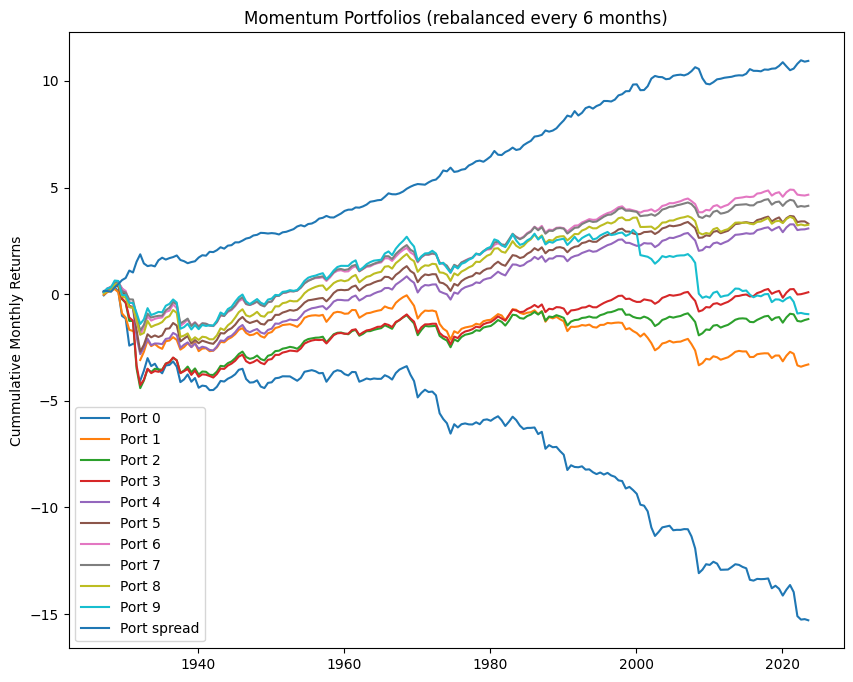

In [72]:
# Log return dataframe
log_ret = np.log1p(port/100)

# Cummulative return dataframe
cum_ret = log_ret.cumsum()
cum_ret.index = pd.to_datetime(cum_ret.index)

# Lineplot
plt.figure(figsize=(10,8))

for col in cum_ret.columns:
    plt.plot(cum_ret[col], label=f"Port {col}")

plt.title("Momentum Portfolios (rebalanced every 6 months)")
plt.ylabel("Cummulative Monthly Returns")
plt.legend()
plt.show()